# Práctica 2: Clasificador Bayesiano
## Gabriel Daniel Aguilar Luna, Zuriel Uzai Rodrígez Agiss
### _Facultad de Ingenierría, Universidad Nacional Autónoma de México_
### _Ciudad de México, México_
#### gabriel.aguilar@ingenieria.unam.edu,  zurieluzai2015@gmail.com

***

### __1. Objetivos__

Clasificar imágenes con 2, 3 o 4 regiones utilizando el clasificador de Bayes.

***

### __2. Introducción__

### Clasificador de Bayes

Un clasificador Naive Bayes es un modelo probabilístico de aprendizaje automático que se utiliza para la tarea de clasificación. El fundamento del clasificador se basa en el teorema de Bayes.

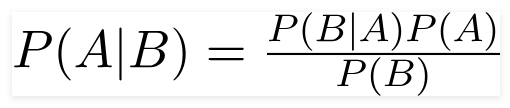

Utilizando el teorema de Bayes, podemos encontrar la probabilidad de que ocurra A, dado que ocurrió B. Aquí, B es la evidencia y A es la hipótesis. La suposición que se hace aquí es que los predictores / características son independientes. Que la presencia de una característica en particular no afecte a la otra. De ahí que se le llame ingenuo.

Para su aplicación se debe e reescribir el Teorema de Bayes como a continuación 
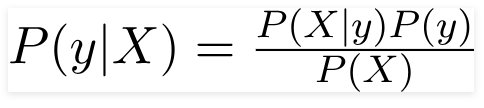

La variable y es la variable de clase (jugar golf, ser una flor), que representa si se pertenece o no a la clase dadas las condiciones. La variable X representa los parámetros/características.
X se da como,
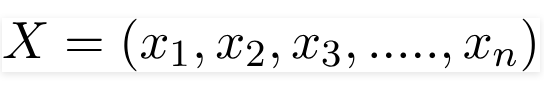

Aquí x_1, x_2… .x_n representan las características, es decir, se pueden asignar a la perspectiva, la temperatura, la humedad y el viento. Sustituyendo X y expandiendo usando la regla de la cadena obtenemos,
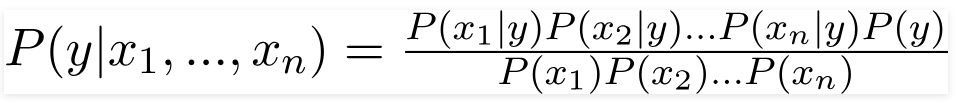

Ahora, puede obtener los valores para cada uno mirando el conjunto de datos y sustituirlos en la ecuación. Para todas las entradas del conjunto de datos, el denominador no cambia, permanece estático. Por tanto, se puede eliminar el denominador y se puede introducir una proporcionalidad.
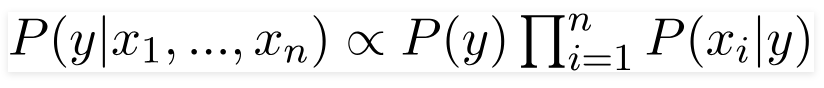

En nuestro caso, la variable de clase (y) tiene solo dos resultados, sí o no. Puede haber casos en los que la clasificación sea multivariante. Por lo tanto, necesitamos encontrar la clase y con máxima probabilidad.
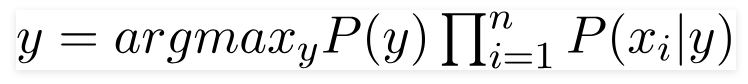
#### Tipos de clasificador Bayes ingenuo:
##### Bayes ingenuo multinomial:
Esto se usa principalmente para problemas de clasificación de documentos, es decir, si un documento pertenece a la categoría de deportes, política, tecnología, etc. Las características / predictores utilizados por el clasificador son la frecuencia de las palabras presentes en el documento.

##### Bernoulli ingenuo Bayes:
Esto es similar a los bayes ingenuos multinomiales, pero los predictores son variables booleanas. Los parámetros que usamos para predecir la variable de clase toman solo valores sí o no, por ejemplo si una palabra aparece en el texto o no.

##### Bayes ingenuo gaussiano:
Cuando los predictores toman un valor continuo y no son discretos, asumimos que estos valores se muestrean a partir de una distribución gaussiana.
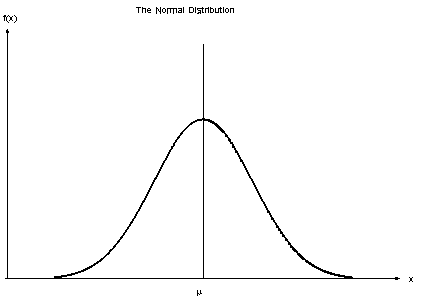
Dado que la forma en que los valores están presentes en el conjunto de datos cambia, la fórmula para la probabilidad condicional cambia a,
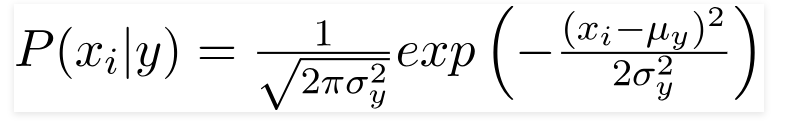

### __3. Desarrollo__

#### __3.1 Realizar preprocesamiento de sus imágenes con un filtro gaussiano__

In [9]:
import matplotlib.pyplot as plt
import cv2
import skimage as ski
import PIL as pil
import imageio as io
import numpy as np
from PIL import Image, ImageFilter
from shapely.geometry import Polygon, MultiPolygon
from descartes import PolygonPatch

import masker

In [10]:
fruta = io.imread('comida/Entrenamiento1.jpg')
fruta.shape, fruta.dtype

((600, 600, 3), dtype('uint8'))

(-0.5, 599.5, 599.5, -0.5)

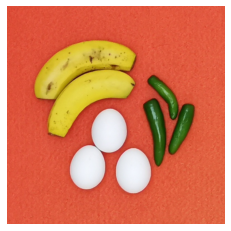

In [11]:
#iamgen original
plt.imshow(fruta)
plt.axis('off')

#### Experimentos con contour con el canal verde:

(0.0, 599.0, 0.0, 599.0)

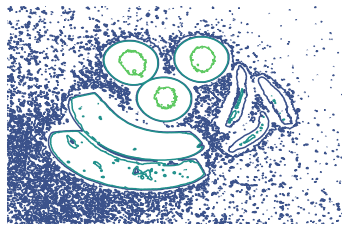

In [12]:
#La funcion contour recibe un arreglo 2D (un solo canal de color (gris))
#En las siguientes celdas envio solo el canal verde de fruta con fruta[:,:,1]
#Experimentando con el numero de niveles indicados a contour:
plt.contour(fruta[:,:,1],3)
plt.axis('off')

(0.0, 599.0, 0.0, 599.0)

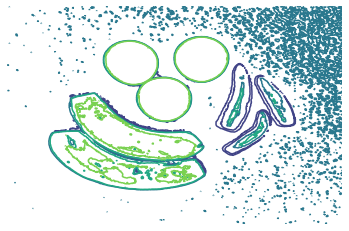

In [13]:
plt.contour(fruta[:,:,1],4)
plt.axis('off')

(0.0, 599.0, 0.0, 599.0)

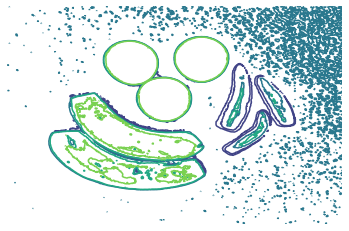

In [14]:
plt.contour(fruta[:,:,1],5)
plt.axis('off')

(0.0, 599.0, 0.0, 599.0)

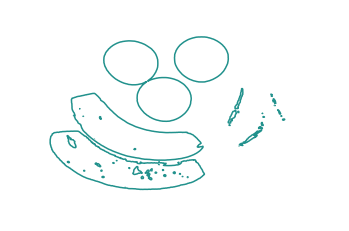

In [15]:
plt.contour(fruta[:,:,1],1)
plt.axis('off')

(-0.5, 599.5, 599.5, -0.5)

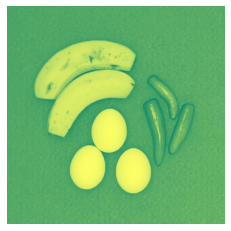

In [16]:
#Se muestra el canal que se ha estado enviando a contour:
plt.imshow(fruta[:,:,1], cmap='summer')
plt.axis('off')

#### Experimentos con contour con la imagen convertida a gris:

(-0.5, 599.5, 599.5, -0.5)

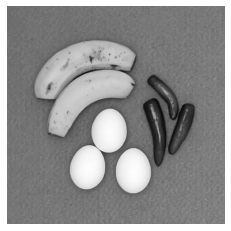

In [17]:
#Utilizando la funcion para convertir de RGB a Gris de cv2,
#Esto con la intencion de evitar la perdida de información al utilizar un unico canal de color:
fruta_gris = cv2.imread("comida/Entrenamiento1.jpg")
fruta_gris = cv2.cvtColor(fruta_gris, cv2.COLOR_BGR2GRAY) #Convertir a escala de grises
plt.imshow(fruta_gris, cmap=plt.cm.gray)
plt.axis('off')

(0.0, 599.0, 0.0, 599.0)

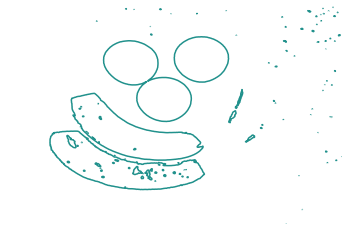

In [18]:
#Probando contour con la imagen gris generada anteriormente:
fruta_contornos = plt.contour(fruta_gris,1)
plt.axis('off')

#### Mostrando una unica linea del resultado de contour:

(62.64461538461538, 366.6169230769231, 86.26289910600255, 263.3067049808429)

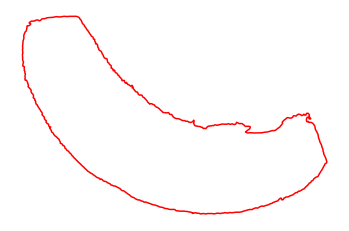

In [19]:
#Probando dibujar una unica linea de las dibujadas por contour:
line = fruta_contornos.collections[1].get_paths()[3].vertices
line = np.copy(line)
plt.plot(line[:,0], line[:,1], 'r-')
plt.axis('off')

#### Mostrando la linea junto con la imagen:

(-0.5, 599.5, 599.5, -0.5)

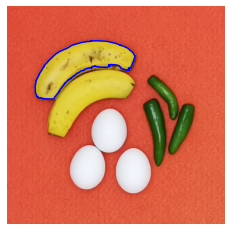

In [20]:
#Ploteo de la linea junto con la imagen:
plt.imshow(fruta)
line = fruta_contornos.collections[1].get_paths()[3].vertices
line = np.copy(line)
plt.plot(line[:,0], line[:,1], 'b')
plt.axis('off')

#### Buscando el otro platano:

(-0.5, 599.5, 599.5, -0.5)

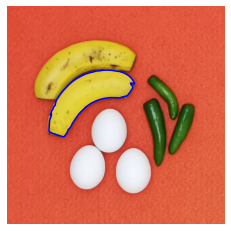

In [21]:
#Aqui probe con multiples indices para ...get_paths()[x]... hasta encontrar el otro platano
plt.imshow(fruta)
line = fruta_contornos.collections[1].get_paths()[37].vertices
line = np.copy(line)
plt.plot(line[:,0], line[:,1], 'b')
plt.axis('off')

#### Entendiendo particularidades de las lineas de los platanos:

In [22]:
#Aquí busco en que caracteristicas coinciden los indices 3 y 37
line = fruta_contornos.collections[1].get_paths()[37].vertices
line2 = fruta_contornos.collections[1].get_paths()[3].vertices
line3 = fruta_contornos.collections[1].get_paths()[5].vertices
line.shape, line2.shape, line3.shape

((868, 2), (924, 2), (7, 2))

In [23]:
#Notando que el tamaño de la primera longitud del arrlego es bastante más grande
len(line)

868

#### Mostrando todas las lineas mayores a 100 en collections[1]:

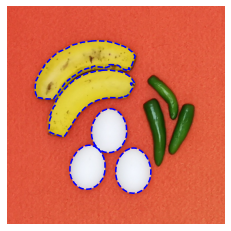

In [24]:
curvas_arr = masker.printImCr(fruta, fruta_contornos, 1, range='200', save='comida_contornos.png')

#### Filtro GAUSSIANO:

In [25]:
#codigo de internet para aplicar filtro Gaussiano xd
#Abriendo imagen con Image
image = Image.open(r'comida\Entrenamiento1.jpg')
  
#Aplicando el filtro de Gaussiano
#Con un valor para el radio igual a 3
image = image.filter(ImageFilter.GaussianBlur(radius = 3))
  
#Se muestra la imagen
image.show()

#Se gurada esta nueva imagen borrosa
image.save("resultados/Entrenamiento1_gaussianBlur.jpg")

#### La imagen borrosa convertida a gris:

(-0.5, 599.5, 599.5, -0.5)

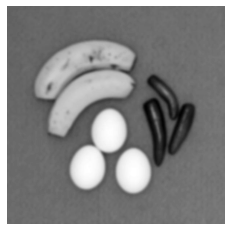

In [26]:
#Esta nueva imagen se abre con cv2 para volverla gris
fruta_gaussiana = cv2.imread("resultados/Entrenamiento1_gaussianBlur.jpg")
fruta_gaussiana = cv2.cvtColor(fruta_gaussiana, cv2.COLOR_BGR2GRAY) #Convertir a escala de grises
plt.imshow(fruta_gaussiana, cmap=plt.cm.gray)
plt.axis('off')

#### Probando contour con la imagen Gaussiana Gris:

(0.0, 599.0, 0.0, 599.0)

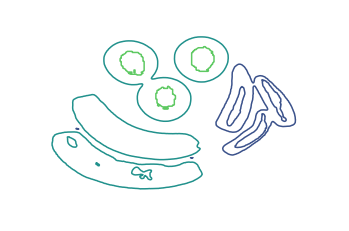

In [27]:
#Probando contour con esta nueva imagen gaussiana gris
fruta_gaussiana_contornos = plt.contour(fruta_gaussiana,2)
plt.axis('off')

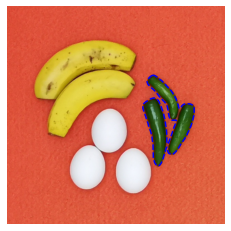

In [28]:
#A partir de aqui busco los intervalos con los que puedo separar a las diferentes clases
curvas_chl_arr = masker.printImCr(fruta, fruta_gaussiana_contornos, 1, range='300', save='comida_gaussiana3_contornos1.png')

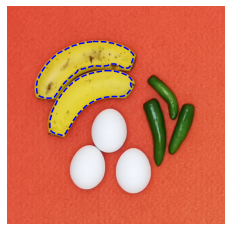

In [29]:
curvas_pltn_arr = masker.printImCr(fruta, fruta_gaussiana_contornos, 2, range='600-760,765', save='comida_gaussiana3_contornos2.png')

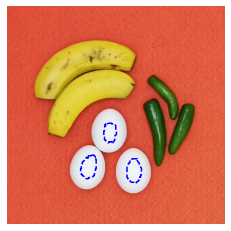

In [30]:
curvas_hvsb_arr = masker.printImCr(fruta, fruta_gaussiana_contornos, 3, range='100', save='comida_gaussiana3_contornos3.png')

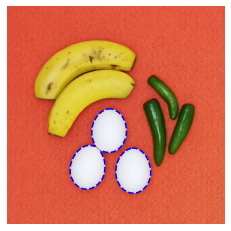

In [31]:
curvas_hvs_arr = masker.printImCr(fruta, fruta_gaussiana_contornos, 2, range='300-600,760-765', save='comida_gaussiana3_contornos2_hvs.png')

### Generando mascaras, separando la imagen por clases:

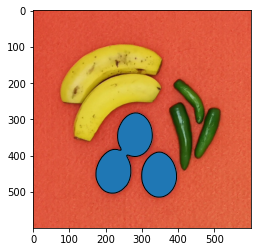

In [32]:
fondo = io.imread('comida/Entrenamiento1.jpg')
lx,ly,lc = fruta.shape
mask_hvs = np.zeros(fruta.shape, dtype=np.uint8)

polygons_hvs = masker.printImPoly(curvas_hvs_arr, fruta)

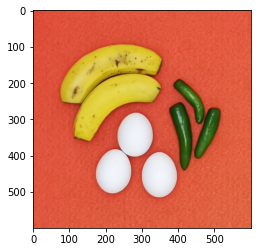

In [33]:
plt.imshow(fruta)
for poly in polygons_hvs:
    patch_poly = PolygonPatch(poly)
    #ax.add_patch(patch_poly)
    for mskx in range(lx):
        for msky in range (ly):
            if (patch_poly.contains_point((mskx,msky))):
                mask_hvs[msky][mskx][0] = fruta[msky][mskx][0]
                mask_hvs[msky][mskx][1] = fruta[msky][mskx][1]
                mask_hvs[msky][mskx][2] = fruta[msky][mskx][2]
                fondo[msky][mskx][0] = 0
                fondo[msky][mskx][1] = 0
                fondo[msky][mskx][2] = 0

#ax.axis('scaled')
plt.show()

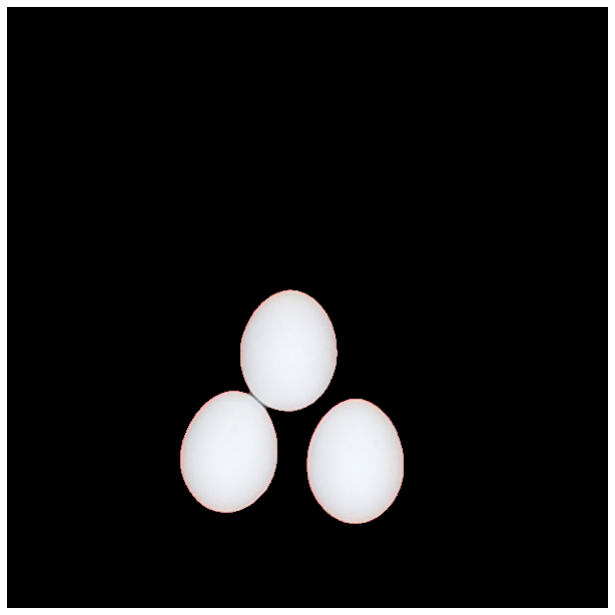

In [34]:
f1 = plt.figure(figsize = (626. / 75., 626. / 75.))
#ax.axis('scaled')
#f1.axis('off')
ax = f1.add_subplot(111)
ax.axis('off')
ax.set_position([0, 0, 1, 1])
ax.set_xlim((0, len(mask_hvs)))
ax.set_ylim((0, len(mask_hvs)))
ax.imshow(mask_hvs)
ax.set(xlim=[-0.5, 600 - 0.5], ylim=[600 - 0.5, -0.5], aspect=1)
f1.savefig('resultados/huevos1_enmascarados.jpeg', bbox_inches='tight', transparent=False, pad_inches = 0)

In [35]:
huevos1_en = io.imread('resultados/huevos1_enmascarados.jpeg')
huevos1_en.shape

(600, 600, 3)

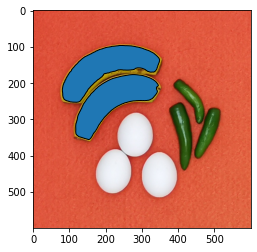

In [36]:
mask_pltn = np.zeros(fruta.shape, dtype=np.uint8)

polygons_pltn = masker.printImPoly(curvas_pltn_arr, fruta)

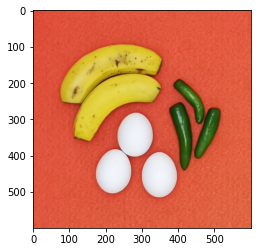

In [37]:
plt.imshow(fruta)
for poly in polygons_pltn:
    patch_poly = PolygonPatch(poly)
    #ax.add_patch(patch_poly)
    for mskx in range(lx):
        for msky in range (ly):
            if (patch_poly.contains_point((mskx,msky))):
                mask_pltn[msky][mskx][0] = fruta[msky][mskx][0]
                mask_pltn[msky][mskx][1] = fruta[msky][mskx][1]
                mask_pltn[msky][mskx][2] = fruta[msky][mskx][2]
                fondo[msky][mskx][0] = 0
                fondo[msky][mskx][1] = 0
                fondo[msky][mskx][2] = 0

#ax.axis('scaled')
plt.show()

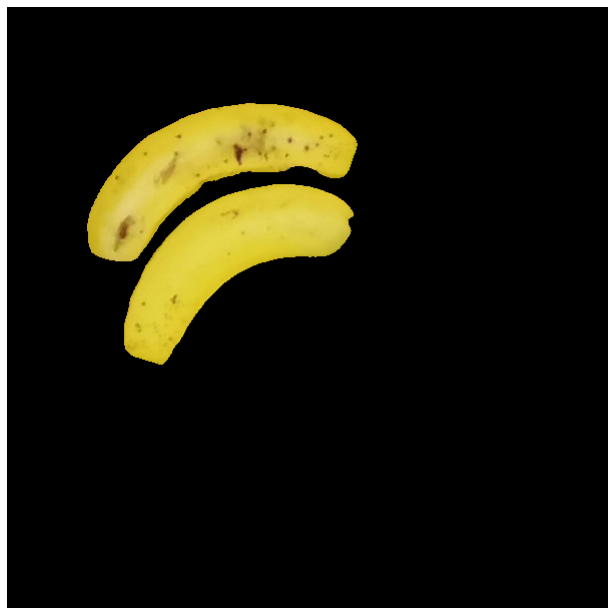

In [38]:
f1 = plt.figure(figsize = (626. / 75., 626. / 75.))
#ax.axis('scaled')
#f1.axis('off')
ax = f1.add_subplot(111)
ax.axis('off')
ax.set_position([0, 0, 1, 1])
ax.set_xlim((0, len(mask_pltn)))
ax.set_ylim((0, len(mask_pltn)))
ax.imshow(mask_pltn)
ax.set(xlim=[-0.5, 600 - 0.5], ylim=[600 - 0.5, -0.5], aspect=1)
f1.savefig('resultados/platanos1_enmascarados.jpeg', bbox_inches='tight', transparent=False, pad_inches = 0)

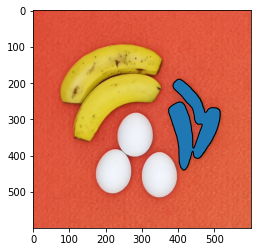

In [39]:
mask_chl = np.zeros(fruta.shape, dtype=np.uint8)

polygons_chl = masker.printImPoly(curvas_chl_arr, fruta)

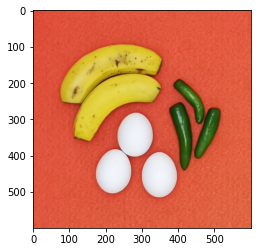

In [40]:
plt.imshow(fruta)
for poly in polygons_chl:
    patch_poly = PolygonPatch(poly)
    #ax.add_patch(patch_poly)
    for mskx in range(lx):
        for msky in range (ly):
            if (patch_poly.contains_point((mskx,msky))):
                mask_chl[msky][mskx][0] = fruta[msky][mskx][0]
                mask_chl[msky][mskx][1] = fruta[msky][mskx][1]
                mask_chl[msky][mskx][2] = fruta[msky][mskx][2]
                fondo[msky][mskx][0] = 0
                fondo[msky][mskx][1] = 0
                fondo[msky][mskx][2] = 0

#ax.axis('scaled')
plt.show()

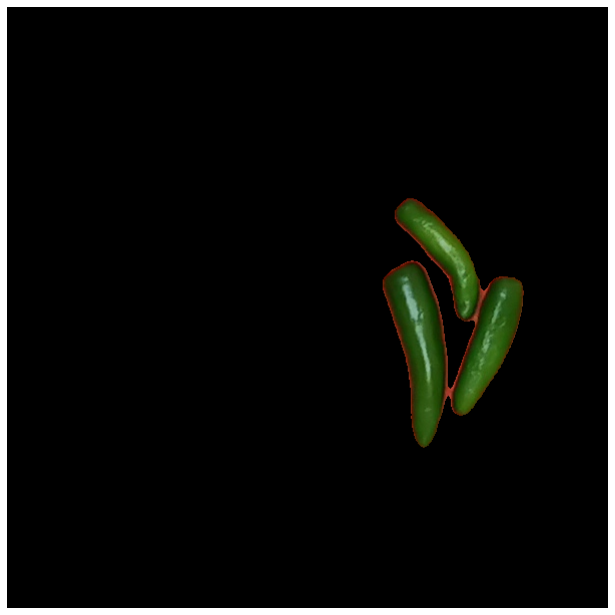

In [41]:
f1 = plt.figure(figsize = (626. / 75., 626. / 75.))
#ax.axis('scaled')
#f1.axis('off')
ax = f1.add_subplot(111)
ax.axis('off')
ax.set_position([0, 0, 1, 1])
ax.set_xlim((0, len(mask_chl)))
ax.set_ylim((0, len(mask_chl)))
ax.imshow(mask_chl)
ax.set(xlim=[-0.5, 600 - 0.5], ylim=[600 - 0.5, -0.5], aspect=1)
f1.savefig('resultados/chiles1_enmascarados.jpeg', bbox_inches='tight', transparent=False, pad_inches = 0)

(-0.5, 599.5, 599.5, -0.5)

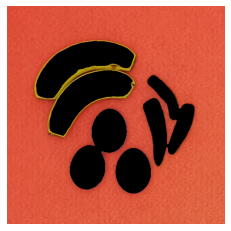

In [42]:
plt.imshow(fondo)
plt.axis('off')

### Conclusiones

Al haber implementado un clasificador de Bayes para la clasificación de 2 o más imágenes nos dimos cuenta de que con la aplicación directa de la regla de Bayes da como resultado una problema computacionalmente costoso que no hace más que incrementarse conforme la cantidad de imágenes de entrenamiento y la complejidad aumenta. Por tante, si bien es un buen punto de partida, no es un clasificador óptimo.


### Referencias:

(s.a) (s.f) _matplotlib.pyplot.plot_ Documentación de Matplotlib. Consultado de 
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html

(s.a) (s.f) _matplotlib.contour.QuadContourSet_ Documentación de Matplotlib. Consultado de 
https://matplotlib.org/stable/api/contour_api.html#matplotlib.contour.QuadContourSet

(s.a) (s.f) _matplotlib.image.AxesImage_ Documentación de Matplotlib. Consultado de 
https://matplotlib.org/stable/api/image_api.html#matplotlib.image.AxesImage

(s.a) (s.f) _matplotlib.pyplot.imshow_ Documentación de Matplotlib. Consultado de 
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html

(s.a) (s.f) _matplotlib.patches.Patch._ Documentación de Matplotlib. Consultado de 
https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Patch.html

(s.a) (s.f) Shapely and geometric objects. Consultado de https://automating-gis-processes.github.io/site/notebooks/L1/geometric-objects.html

(s.a) (s.f) _matplotlib.path._ Documentación de Matplotlib. Consultado de https://matplotlib.org/stable/api/path_api.html

(s.a) (s.f) _matplotlib.pyplot.plot._ Documentación de Matplotlib. Consultado de https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html

(s.a) (s.f) Image Resolution and DPI. Consultado de https://largeprinting.com/resources/image-resolution-and-dpi.html

(s.a)(26 de dic, 2020) Apply a Gauss filter to an image with Python. Geeks for Geeks. Consultado de
https://www.geeksforgeeks.org/apply-a-gauss-filter-to-an-image-with-python/

(s.a) (14 de julio, 2019) _Python PIL | GaussianBlur() method._ Geeks for Geeks. Consultado de https://www.geeksforgeeks.org/python-pil-gaussianblur-method/

gene (13 de abril, 2017) _Geopandas Polygon to matplotlib patches Polygon conversion_ Stack Exchange. Consultado de https://gis.stackexchange.com/questions/197945/geopandas-polygon-to-matplotlib-patches-polygon-conversion

gene (4 de junio, 2014). _Converting Matplotlib contour objects to Shapely objects._ Stack Overflow. Consultado de https://gis.stackexchange.com/questions/99917/converting-matplotlib-contour-objects-to-shapely-objects

Gillies, S.(27 de sep, 2020) _The Shapely User Manual._ Shapely. Consultado de https://shapely.readthedocs.io/en/stable/manual.html

jodag. (6 de mayo, 2020) _Matplotlib - unable to save image in same resolution as original image._ Stack Overflow. Consultado de https://stackoverflow.com/questions/34768717/matplotlib-unable-to-save-image-in-same-resolution-as-original-image#34769840

Ghandi, R. (5 de Mayo, 2018) _Naive Bayes Classifier_ Towards Data Science. Consultado de https://towardsdatascience.com/naive-bayes-classifier-81d512f50a7c

tom10 (23 de Marzo, 2015) Python - convert contours to image. Stack Overflow. Consultado de
https://stackoverflow.com/questions/29213238/python-convert-contours-to-image#29214175
